# LSTM for KOSPI Forecasting Example

In [1]:
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# to set data path
dataPath = 'https://raw.githubusercontent.com/stillxyxon/py_ml_analysis/master/'
# dataPath = 'C:/YONG/m1710/myPydata/'

# https://www.kaggle.com/amarpreetsingh/stock-prediction-lstm-using-keras/notebook 


# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

### Data Loading 

                 High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2020-11-09  2459.1499  2434.5200  2438.6299  2447.2000  1354900.0  2447.2000
2020-11-10  2457.9399  2435.5901  2453.9500  2452.8301  1464200.0  2452.8301
2020-11-11  2488.0400  2459.5000  2459.5000  2485.8701  1272000.0  2485.8701
2020-11-12  2488.7900  2467.0400  2482.6799  2475.6201  1278100.0  2475.6201
2020-11-13  2482.3899  2460.9600  2470.1201  2470.5500   601672.0  2470.5500
Close Median 2094.885009765625
count    1434.0000
mean     2146.4978
std       187.2142
min      1457.6400
25%      2011.4275
50%      2094.8850
75%      2293.4350
max      2598.1899
Name: Close, dtype: float64
             High     Low    Open   Close  Volume  Adj Close
High       1.0000  0.3569  0.9986  0.9978 -0.0337     0.9978
Low        0.3569  1.0000  0.3572  0.3588  0.0445     0.3588
Open       0.9986  0.3572  1.0000  0.9960 -0.0456     0.9960
Close 

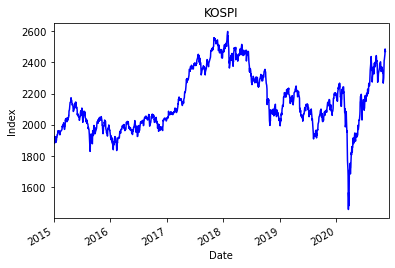

In [2]:
# reading in KOSPI history

import pandas_datareader as pdr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
 
pd.set_option('precision', 4)
 
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 12, 3)
df_null = pdr.DataReader("^KS11","yahoo",start,end)
df = df_null.dropna()
 
kospi_chart = df.Close.plot(style='b')
kospi_chart.set_title("KOSPI")
kospi_chart.set_ylabel("Index")
kospi_chart.set_xlim(str(start), str(end))
 
print(df.tail())
 
print("Close Median", df['Close'].median())
print(df['Close'].describe())
print(df.corr())
 
plt.show()


In [3]:
# set Close as taget to predict 

data = df[['Close']]
print(data.columns)
print(data.tail())

cl0 = data.Close

Index(['Close'], dtype='object')
                Close
Date                 
2020-11-09  2447.2000
2020-11-10  2452.8301
2020-11-11  2485.8701
2020-11-12  2475.6201
2020-11-13  2470.5500


KOSPI - 02-Jan-2015 ~ 13-Nov-2020


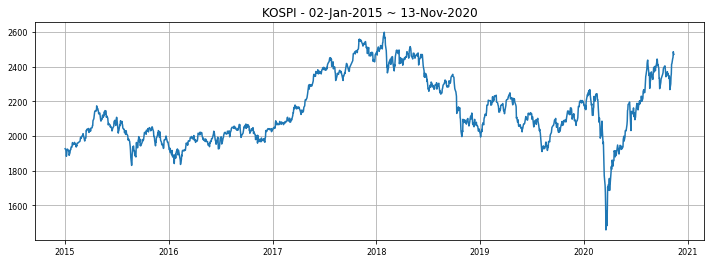

In [4]:
fromtimestampStr = cl0.index[0].strftime("%d-%b-%Y")
totimestampStr = cl0.index[len(cl0)-1].strftime("%d-%b-%Y")
periodText = 'KOSPI - ' + fromtimestampStr + ' ~ ' + totimestampStr

print(periodText)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0)
ax.grid()
plt.title(periodText)
ax.tick_params(axis='both', labelsize=8)
plt.show()

### Data Preparation

In [119]:
# get deviations from the previous day

print(cl0.head())
cl_startval = cl0[0]
print(cl_startval)

cl = cl0.subtract(cl0.shift(1))
cl_orgnl = cl.copy()[1:]

# to check outlier COVID-19?
# plt.hist(cl)
# plt.show()

cl = cl[1:]
print(len(cl))
print(cl.tail())
print(cl0.tail())

Date
2015-01-02    1926.4399
2015-01-05    1915.7500
2015-01-06    1882.4500
2015-01-07    1883.8300
2015-01-08    1904.6500
Name: Close, dtype: float64
1926.43994140625
1433
Date
2020-11-09    30.7000
2020-11-10     5.6301
2020-11-11    33.0400
2020-11-12   -10.2500
2020-11-13    -5.0701
Name: Close, dtype: float64
Date
2020-11-09    2447.2000
2020-11-10    2452.8301
2020-11-11    2485.8701
2020-11-12    2475.6201
2020-11-13    2470.5500
Name: Close, dtype: float64


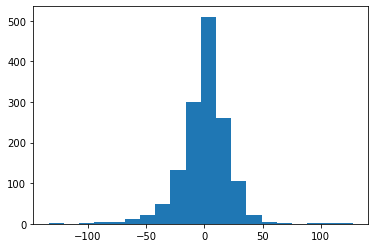

In [120]:
plt.hist(cl_orgnl, bins=20);

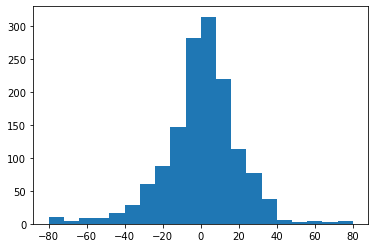

In [121]:
# adjust oultier
cl = np.where(cl>80,80,cl)
cl = np.where(cl<-80,-80,cl)

plt.hist(cl, bins=20);

[-10.68994141 -33.30004883   1.38000488  20.82006836  20.04992676
  -3.75        -3.80993652  -3.47998047   0.47998047 -26.01000977] 
 [0.43318787 0.29187469 0.50862503 0.63012543 0.62531204 0.4765625
 0.4761879  0.47825012 0.50299988 0.33743744]


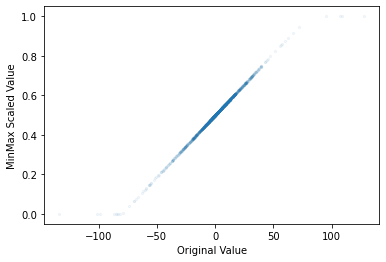

In [126]:
cl_train = cl[:(len(cl)-90)]

# Scale the data
clt_max, clt_min = cl_train.max(), cl_train.min()
# print(clt_max, clt_min)

cl = np.array(cl).reshape(cl.shape[0],1)
cl = (cl - clt_min) / (clt_max-clt_min)

# check values before and after scaling
print(np.array(cl_orgnl[:10]),'\n', cl.flatten()[:10])

# What is MinMax Scaling?

plt.scatter(cl_orgnl, cl.flatten(), alpha=0.05, s=5)
plt.xlabel('Original Value')
plt.ylabel('MinMax Scaled Value')
plt.show()


- scaler는 지정된 구간에서(train set) 기준값을 구해야함 
(후에 사용할 테스트 기간, 실제 운영시 새로운 데이터 투입 처리 용으로)
- 운영상황의 예측에서는 신규 데이터가 들어오며 (데이터 추가, 데이터셋 이동), 미래 장기간을 예측하는 경우라면 예측을 input으로 해서 예측을 계속하는 방안 밖에 없음

In [201]:
# a user function to process the data into 7 day look back(=lb) slices

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb = 10 # [5, 10, 15]  # lb = look back period in days
X,y = processData(cl,lb) 

# 최근 60개 일자의 값은 테스트용으로
# 테스트 이전 30개 값은 Validation 용으로 모델링중 사용

print(len(y), len(y)-60, len(y)-90)
a, b, c = len(y), len(y)-60, len(y)-90 
X_train, X_val, X_test = X[:c], X[c:b],X[b:]
y_train, y_val, y_test = y[:c], y[c:b],y[b:]

print('Train set :', X_train.shape[0], y_train.shape[0])
print('Validation set :', X_val.shape[0], y_val.shape[0])
print('Test set :', X_test.shape[0], y_test.shape[0])

print('\nTraining Set : \n', X_train[:2])
# slides one day

1422 1362 1332
Train set : 1332 1332
Validation set : 30 30
Test set : 60 60

Training Set : 
 [[0.43318787 0.29187469 0.50862503 0.63012543 0.62531204 0.4765625
  0.4761879  0.47825012 0.50299988 0.33743744]
 [0.29187469 0.50862503 0.63012543 0.62531204 0.4765625  0.4761879
  0.47825012 0.50299988 0.33743744 0.59056244]]


train Y mean =  0.5011137398155602


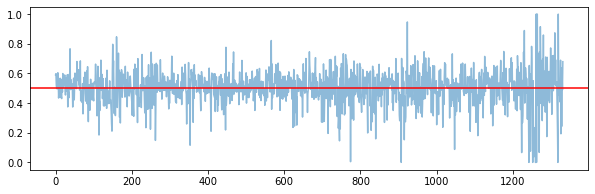

test Y mean =  0.5046260579427083


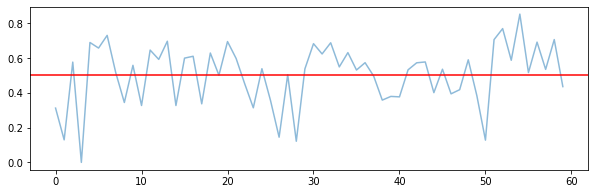

In [202]:
print('train Y mean = ',y_train.mean())
plt.figure(figsize=(10,3))
plt.plot(y_train, alpha=0.5)
plt.axhline(0.5, color='red')
plt.show()

print('test Y mean = ',y_test.mean())
plt.figure(figsize=(10,3))
plt.plot(y_test, alpha=0.5)
plt.axhline(0.5, color='red');

### Model Building

In [221]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# to adjust learning rate
from keras import optimizers 
optimizer = optimizers.Adam(lr=0.0000003)


# Build the model
model = Sequential()
model.add(LSTM(64,input_shape=(lb,1), return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(optimizer=optimizer,loss='mean_squared_error') # loss = 'mae' or 'mean_squared_error'

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=200,
                    validation_data=(X_val,y_val),shuffle=True, batch_size = 10)


Epoch 1/200
134/134 [==============================] - 6s 43ms/step - loss: 0.2587 - val_loss: 0.3217
Epoch 2/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2577 - val_loss: 0.3205
Epoch 3/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2566 - val_loss: 0.3192
Epoch 4/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2555 - val_loss: 0.3180
Epoch 5/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2544 - val_loss: 0.3167
Epoch 6/200
134/134 [==============================] - 5s 34ms/step - loss: 0.2533 - val_loss: 0.3155
Epoch 7/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2522 - val_loss: 0.3142
Epoch 8/200
134/134 [==============================] - 4s 34ms/step - loss: 0.2512 - val_loss: 0.3129
Epoch 9/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2500 - val_loss: 0.3116
Epoch 10/200
134/134 [==============================] - 4s 34ms/step - loss: 0.248

134/134 [==============================] - 4s 33ms/step - loss: 0.1372 - val_loss: 0.1782
Epoch 81/200
134/134 [==============================] - 5s 34ms/step - loss: 0.1350 - val_loss: 0.1757
Epoch 82/200
134/134 [==============================] - 4s 34ms/step - loss: 0.1331 - val_loss: 0.1732
Epoch 83/200
134/134 [==============================] - 4s 33ms/step - loss: 0.1310 - val_loss: 0.1707
Epoch 84/200
134/134 [==============================] - 5s 34ms/step - loss: 0.1289 - val_loss: 0.1682
Epoch 85/200
134/134 [==============================] - 4s 33ms/step - loss: 0.1267 - val_loss: 0.1657
Epoch 86/200
134/134 [==============================] - 4s 33ms/step - loss: 0.1247 - val_loss: 0.1631
Epoch 87/200
134/134 [==============================] - 5s 34ms/step - loss: 0.1226 - val_loss: 0.1606
Epoch 88/200
134/134 [==============================] - 5s 34ms/step - loss: 0.1205 - val_loss: 0.1580
Epoch 89/200
134/134 [==============================] - 5s 37ms/step - loss: 0.1183 - 

134/134 [==============================] - 5s 34ms/step - loss: 0.0161 - val_loss: 0.0189
Epoch 160/200
134/134 [==============================] - 5s 34ms/step - loss: 0.0159 - val_loss: 0.0186
Epoch 161/200
134/134 [==============================] - 5s 34ms/step - loss: 0.0159 - val_loss: 0.0184
Epoch 162/200
134/134 [==============================] - 5s 35ms/step - loss: 0.0160 - val_loss: 0.0181
Epoch 163/200
134/134 [==============================] - 5s 36ms/step - loss: 0.0158 - val_loss: 0.0179
Epoch 164/200
134/134 [==============================] - 5s 36ms/step - loss: 0.0158 - val_loss: 0.0178
Epoch 165/200
134/134 [==============================] - 5s 36ms/step - loss: 0.0157 - val_loss: 0.0176
Epoch 166/200
134/134 [==============================] - 6s 42ms/step - loss: 0.0157 - val_loss: 0.0174
Epoch 167/200
134/134 [==============================] - 5s 36ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 168/200
134/134 [==============================] - 5s 35ms/step - loss: 

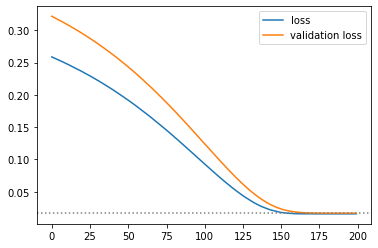

min 1% loss (loss, val_loss) :  0.015617216331884265 0.016721659824252128
mean of last 10 losses (loss, val_loss) :  0.01567535176873207 0.016743224672973157


In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'validation loss'], loc='upper right')
plt.axhline(np.percentile(history.history['val_loss'],5), color='grey',
           linestyle=':')
plt.show()

# 작은순 1% loss 지점은? - 일회성의 큰 변동을 무시하기 위한 방안
print('min 1% loss (loss, val_loss) : ', np.percentile(history.history['loss'],1), np.percentile(history.history['val_loss'],1))
# 마지막 10개 epoch의 loss 평균값은?
print('mean of last 10 losses (loss, val_loss) : ', np.mean(history.history['loss'][-10:]), np.mean(history.history['val_loss'][-10:]))

### Assessment of LSTM Predictions

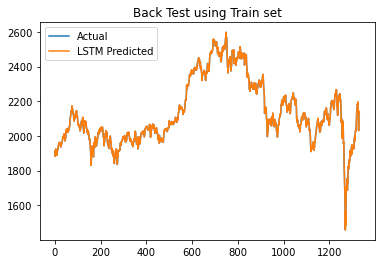

MAE :  0.49859359676952475


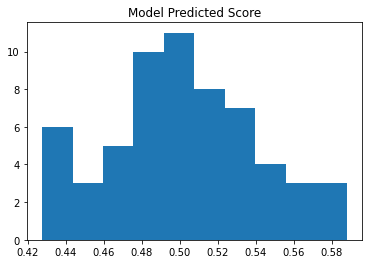

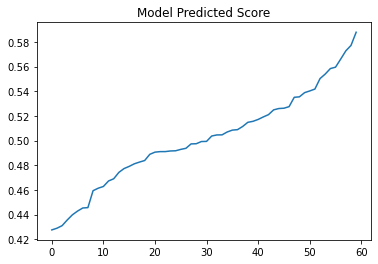

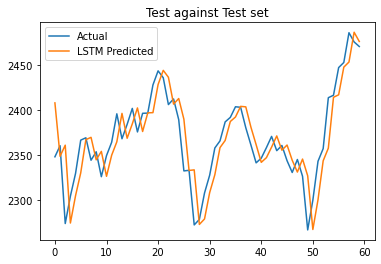

MAE :  21.96210157374541


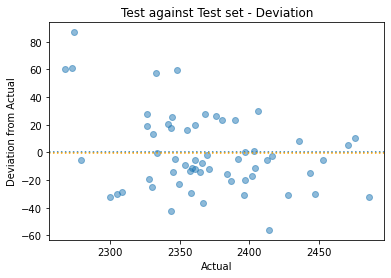

In [224]:
# 예측과 실제를 비교하는 챠트를 생성하는 함수
# 데이터셋을 변경하는 경우에도 재사용

def PredActPlot(x, y, title):
    y = list(cl0[:(len(y)+1)])
    plt.plot(y[1:])
    Xt = model.predict(x)
    Xt = (Xt * (clt_max-clt_min)) + clt_min
    Xt = y[1:] + Xt.reshape(-1,)
    plt.plot(Xt)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(y[1:] - Xt).mean())
    

PredActPlot(X_train, y_train, 'Back Test using Train set')    


test_prev = list(cl0[-(60+1):])[:60]  
test_actual = list(cl0[-(60):])
Xt = model.predict(X_test).reshape(-1,)
Xta = Xt.reshape(-1,)
# reverse scale
Xt = (Xt * (clt_max-clt_min)) + clt_min
test_predicted = test_prev + Xt


plt.hist(Xta)
plt.title('Model Predicted Score')
plt.show()

plt.plot(np.sort(Xta))
plt.title('Model Predicted Score')
plt.show()


# 데이터셋을 변경하는 경우에도 재사용 고려해서 함수화

def PredActPlot(x, y, title, dstype):
    plt.plot(test_actual)
    plt.plot(test_predicted)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(test_predicted - test_actual).mean())
    
    
PredActPlot(X_test, y_test, 'Test against Test set', 'test')   

def PredActDevPlot(x, y, title):    
    plt.scatter(test_actual, test_predicted - test_actual, alpha=0.5)
    plt.axhline(0, linestyle=':')
    plt.axhline(np.mean(test_predicted - test_actual), linestyle=':',
               color='orange')
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Deviation from Actual')
    plt.show()
     
PredActDevPlot(X_test, y_test, 'Test against Test set - Deviation')       

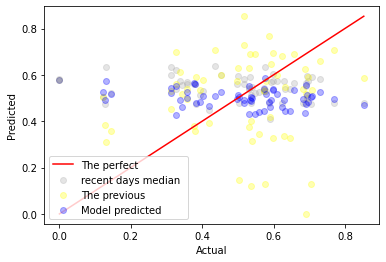

correlation between actual and the previous :  0.05116463492294724
correlation between actual and recent days median :  -0.1716692882477512
correlation between actual and model predicted :  -0.28921864962787913


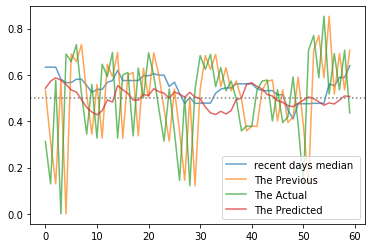

MAE of the previous :  22.0840087890625
MAE of the recent days median :  21.958257484436043
MAE of the predicted :  21.96210157374541


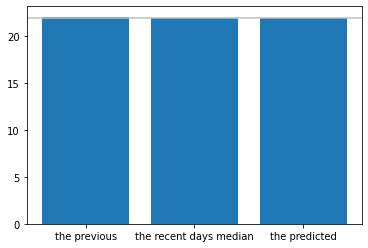

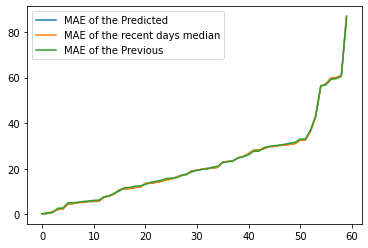

In [236]:
# a scatter plot of median of past 7 days and the target?
# a scatter plot of the previous day and the target?

X_prv = X_test[:,X_test.shape[1]-1,:].reshape(-1,)

plt.scatter(y_test, np.median(X_test, axis=1), alpha=0.3, color='darkgrey')
plt.scatter(y_test, X_prv, alpha=0.3, color='yellow')
plt.scatter(y_test, Xta, alpha=0.3, color='blue')
plt.plot([0,y_test.max()],[0,y_test.max()], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(['The perfect','recent days median ','The previous', 'Model predicted'])
plt.show()


print('correlation between actual and the previous : ', np.corrcoef(y_test, X_prv)[0,1])
print('correlation between actual and recent days median : ', np.corrcoef(y_test, np.median(X_test, axis=1).flatten())[0,1])
print('correlation between actual and model predicted : ', np.corrcoef(y_test, Xta)[0,1])


plt.plot(np.median(X_test, axis=1), alpha=0.7)
plt.plot(X_prv, alpha=0.7)
plt.plot(y_test, alpha=0.7)
plt.plot(Xta, alpha=0.7)
plt.legend(['recent days median ','The Previous', 'The Actual', 'The Predicted'])
plt.axhline(Xta.mean(), color='grey', linestyle=":")
plt.show()

test_med_pst = (np.median(X_test, axis=1).reshape(-1) * (clt_max-clt_min)) + clt_min  + test_prev 

print('MAE of the previous : ', abs(np.array(test_prev)  - np.array(test_actual)).mean()) 
print('MAE of the recent days median : ', abs(np.array(test_med_pst) - np.array(test_actual)).mean())
print('MAE of the predicted : ', abs(test_predicted - test_actual).mean())

ErrorList = np.array([abs(np.array(test_prev)  - np.array(test_actual)).mean(), abs(np.array(test_med_pst) - np.array(test_actual)).mean(), abs(test_predicted - test_actual).mean()])
plt.bar(['the previous','the recent days median','the predicted'], ErrorList)
plt.axhline(ErrorList.min(), color='silver')
plt.show()

plt.plot(np.sort(abs(test_predicted - test_actual)))
plt.plot(np.sort(abs(np.array(test_med_pst)  - np.array(test_actual))))
plt.plot(np.sort(abs(np.array(test_prev)  - np.array(test_actual))))
plt.legend(['MAE of the Predicted', 'MAE of the recent days median', 'MAE of the Previous'])
plt.show()

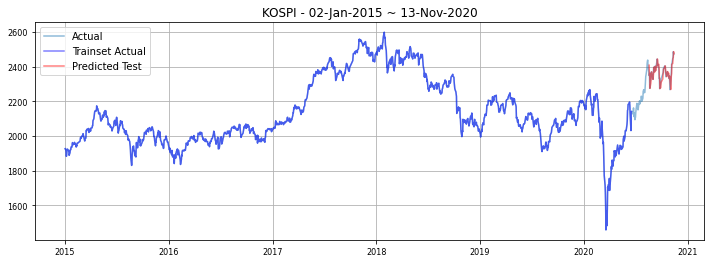

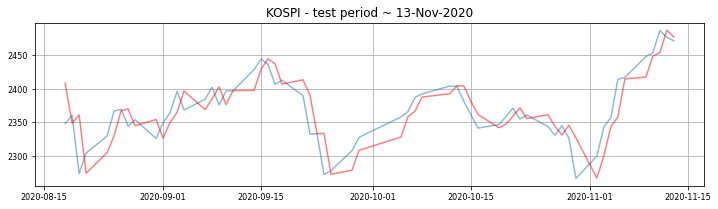

In [232]:
clpred = cl0[-60:].copy()
clpred.loc[:] = test_predicted

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0, alpha=0.5)
ax.plot(cl0[:(len(y_train))], color='blue', alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
plt.title(periodText)
ax.tick_params(axis='both', labelsize=8)
plt.legend(['Actual','Trainset Actual', 'Predicted Test'])
plt.show()


fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(cl0[-60:], alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
titleText = 'KOSPI - test period ~ ' + totimestampStr
plt.title(titleText )
ax.tick_params(axis='both', labelsize=8)
plt.show()




[예측결과 종합]
- 전날 값 (최근) 의 영향을 받을 수 밖에 없기에 이미 전날 값을 뒤따라가는 패턴과 유사하게 예측하는 모습
- 자기 시계열만으로는 전날 값으로부터의 변화를 많이 설명하지 못함
- 하지만, 전날값이 불변한다고 가정하는 것에 비해서는 미세하게 오차 적음
- 값 자체에 대한 예측에서는 전날을 이기지 못한 것에 비해서는 전날로부터의 변화를 예측하는 방식으로 오차 감소